In [1]:
!nvidia-smi

Sun Mar  7 16:55:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   31C    P0    23W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

- https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=goRmGIRI5cfC

# setup

http://localhost:8080/notebooks/git/product-category/notebooks/prep_20210304A1.ipynb

In [2]:
prfx_prp = 'prep_20210307B1'

In [3]:
HOME = "/data/git/product-category"
p_out = f'{HOME}/data/transformer_20210307A1'
!mkdir -p {p_out}

In [4]:
sz = int(1e4)
DATA2USE = f'{HOME}/data/data_sample_{sz}__{prfx_prp}.csv'

# eda 

In [5]:
import pandas as pd
import numpy as np
from collections import Counter

In [6]:
%%time
# df = pd.read_csv(f'../data/data__{prfx_prp}.csv')
# df = pd.read_csv(f'{HOME}/data/data_sample__{prfx_prp}.csv')
df = pd.read_csv(DATA2USE, nrows=1000)
print(df.shape)
df.sample(3)

(1000, 3)
CPU times: user 8.15 ms, sys: 20 µs, total: 8.17 ms
Wall time: 6.71 ms


,category,title,is_validation
580,"Clothing, Shoes & Jewelry|Women|Clothing|Tops,...",Najia Symbol Womens Casual Plus Size Long Slee...,1
542,Office Products|Office Electronics|Video Proje...,Duogreen Toshiba D95-LMP Projection TV Replace...,0
619,Electronics|Accessories & Supplies|Telephone A...,"BATT-507 - Ni-CD, 7.2 Volt, 500 mAh, Ultra Hi-...",0


In [7]:
df = pd.read_csv(DATA2USE, nrows=1000)


In [10]:
MIN_CNT = 50
cat2cnt = Counter((j for i in df.category.apply(lambda x: x.split('|')) for j in i))
i2cat = sorted(k for k,v in cat2cnt.items() if v>MIN_CNT)
cat2i = {v:k for k,v in enumerate(i2cat)}

print("len(i2cat)", len(i2cat))
print("|".join(i2cat))

len(i2cat) 10
Accessories|Automotive|Books|Clothing|Clothing, Shoes & Jewelry|Electronics|Home & Kitchen|Sports & Outdoors|Toys & Games|Women


In [31]:
cat2cnt.most_common()

[('Books', 213),
 ('Clothing, Shoes & Jewelry', 171),
 ('Women', 103),
 ('Home & Kitchen', 89),
 ('Clothing', 83),
 ('Sports & Outdoors', 64),
 ('Automotive', 64),
 ('Accessories', 63),
 ('Electronics', 61),
 ('Toys & Games', 52),
 ('Men', 47),
 ('Kindle Store', 41),
 ('Kindle eBooks', 40),
 ('Tools & Home Improvement', 40),
 ('Shoes', 40),
 ('Sports & Fitness', 35),
 ('Cell Phones & Accessories', 34),
 ('Replacement Parts', 33),
 ('Imported', 32),
 ('Patio, Lawn & Garden', 28),
 ('CDs & Vinyl', 28),
 ('Kitchen & Dining', 27),
 ('Literature & Fiction', 26),
 ('Literature &amp; Fiction', 24),
 ('Office Products', 22),
 ('Home Dcor', 22),
 ('Cases, Holsters & Sleeves', 21),
 ('Computers & Accessories', 21),
 ('Jewelry', 20),
 ('Arts, Crafts & Sewing', 20),
 ('Novelty & More', 20),
 ("Children's Books", 20),
 ('Novelty', 17),
 ('Movies & TV', 16),
 ('Outdoor Recreation', 16),
 ('Pet Supplies', 16),
 ('Office & School Supplies', 15),
 ('Camera & Photo', 14),
 ('T-Shirts', 14),
 ('Industria

# dataset

In [15]:
from argparse import ArgumentParser
import pytorch_lightning as pl
from transformers.optimization import AdamW

from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoTokenizer
import torch

def mk_tensors(txt, tokenizer, max_seq_length):
    tok_res = tokenizer(
        txt, truncation=True, padding='max_length', max_length=max_seq_length
    )
    input_ids = tok_res["input_ids"]
    attention_mask = tok_res["attention_mask"]
    input_ids = torch.tensor(input_ids)
    attention_mask = torch.tensor(attention_mask)
    return input_ids, attention_mask

def mk_ds(txt, tokenizer, max_seq_length, ys):
    input_ids, attention_mask = mk_tensors(txt, tokenizer, max_seq_length)
    return TensorDataset(input_ids, 
                         attention_mask, 
                         torch.tensor(ys)) 

class PCDataModule(pl.LightningDataModule):
    def __init__(self, 
                 model_name_or_path, 
                 max_seq_length, 
                 min_products_for_category,
                 train_batch_size,
                 val_batch_size,
                 dataloader_num_workers,
                 data_file_path=None,
                 dataframe=None):
        super().__init__()
        self.data_file_path = data_file_path
        self.dataframe = dataframe
        self.min_products_for_category = min_products_for_category
        self.model_name_or_path = model_name_or_path
        self.max_seq_length = max_seq_length
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.dataloader_num_workers = dataloader_num_workers
        self.num_classes = None
      
    def prepare_data(self):
        #prepare_data is called from a single process (e.g. GPU 0). Do not use it to assign state (self.x = y).
        _ = AutoTokenizer.from_pretrained(self.model_name_or_path)

    def setup(self, stage=None):
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name_or_path)
        if self.dataframe is None:
            self.dataframe = pd.read_csv(self.data_file_path)
            self.dataframe.dropna(inplace=True)

        
#         self.dataframe = self.dataframe[self.dataframe.title.notna()].copy()
        
        cats = self.dataframe.category.apply(lambda x: x.split('|'))
        cat2cnt = Counter((j for i in cats for j in i))
        i2cat = sorted(k for k,v in cat2cnt.items() if v>self.min_products_for_category)
        cat2i = {v:k for k,v in enumerate(i2cat)}
        self.num_classes = len(i2cat)
        self.i2cat, self.cat2i = i2cat, cat2i
        
        ys = np.zeros((len(self.dataframe), len(i2cat)))
        for i,cats in enumerate(self.dataframe.category):
            idx_pos = [cat2i[cat] for cat in cats.split('|') if cat in cat2i]
            ys[i,idx_pos] = 1
        
        msk_val = self.dataframe.is_validation==1
        self.df_trn = self.dataframe[~msk_val]
        self.df_val = self.dataframe[ msk_val]
        idx_trn = np.where(~msk_val)[0]
        idx_val = np.where( msk_val)[0]
        self.ys_trn, self.ys_val = ys[idx_trn], ys[idx_val]
        
        self.train_dataset = mk_ds(list(self.df_trn.title), self.tokenizer, self.max_seq_length, self.ys_trn)
        self.eval_dataset  = mk_ds(list(self.df_val.title), self.tokenizer, self.max_seq_length, self.ys_val)
        
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.train_batch_size,
            num_workers=self.dataloader_num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            self.eval_dataset,
            batch_size=self.val_batch_size,
            num_workers=self.dataloader_num_workers,
        )

# model

In [16]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel


def getaccu(logits, ys):
    return ((logits>0.).int() == ys).float().mean()

class PCModel(pl.LightningModule):
    def __init__(self, model_name_or_path, freeze_bert, num_classes, learning_rate, adam_beta1, adam_beta2, adam_epsilon):
        super().__init__()
        self.save_hyperparameters()
        self.model_name_or_path = model_name_or_path
        self.bert = AutoModel.from_pretrained(self.model_name_or_path)
        self.freeze_bert = freeze_bert
        if freeze_bert==True:
            for param in self.bert.parameters():
                param.requires_grad = False
        self.num_classes = num_classes
        self.W = nn.Linear(self.bert.config.hidden_size, self.num_classes)

    def prepare_data(self):
        #prepare_data is called from a single process (e.g. GPU 0). Do not use it to assign state (self.x = y).
        _ = AutoModel.from_pretrained(self.model_name_or_path)

    def forward(self, input_ids, attention_mask):
        h = self.bert(input_ids, attention_mask)['last_hidden_state']
        h_cls = h[:, 0]
        return self.W(h_cls)
    
    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, ys = batch    
        logits = self(input_ids, attention_mask)
        loss = F.binary_cross_entropy_with_logits(logits, ys)
        accu = getaccu(logits, ys)
        self.log('train_loss', loss, on_epoch=True)
        self.log('train_accu', accu, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask, ys = batch    
        logits = self(input_ids, attention_mask)
        loss = F.binary_cross_entropy_with_logits(logits, ys)
        accu = getaccu(logits, ys)
        self.log('valid_loss', loss, on_step=False, sync_dist=True)
        self.log('valid_accu', accu, on_step=False, sync_dist=True)
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(),
                          self.hparams.learning_rate,
                          betas=(self.hparams.adam_beta1,
                                 self.hparams.adam_beta2),
                          eps=self.hparams.adam_epsilon,)
        return optimizer    
    
    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument('--learning_rate', type=float, default=5e-5)
        parser.add_argument('--adam_beta1', type=float, default=0.9)
        parser.add_argument('--adam_beta2', type=float, default=0.999)
        parser.add_argument('--adam_epsilon', type=float, default=1e-8)
        return parser

# train

In [17]:
parser = ArgumentParser()

parser.add_argument('--model_name_or_path', type=str,
                    default="distilbert-base-cased")
parser.add_argument('--freeze_bert', action='store_true')
parser.add_argument('--max_seq_length', type=int, default=128)
parser.add_argument('--min_products_for_category', type=int, default=100)
parser.add_argument('--train_batch_size', type=int, default=64)
parser.add_argument('--val_batch_size', type=int, default=128)
parser.add_argument("--dataloader_num_workers", type=int, default=8)

parser = pl.Trainer.add_argparse_args(parser)
parser = PCModel.add_model_specific_args(parser)

args = parser.parse_args([
    '--default_root_dir', p_out,
    '--freeze_bert',
])


data_module = PCDataModule(
    model_name_or_path=args.model_name_or_path,
#     data_file_path=f'{HOME}/data/data_sample__{prfx_prp}.csv',
    data_file_path=DATA2USE,
    min_products_for_category=args.min_products_for_category,
    max_seq_length=args.max_seq_length,
    train_batch_size=args.train_batch_size,
    val_batch_size=args.val_batch_size,
    dataloader_num_workers=args.dataloader_num_workers,
)

data_module.prepare_data()

In [18]:
%%time
data_module.setup()

CPU times: user 1.76 s, sys: 156 ms, total: 1.91 s
Wall time: 642 ms


In [19]:
pcmodel = PCModel(
    model_name_or_path=args.model_name_or_path,
    freeze_bert=args.freeze_bert,
    num_classes= data_module.num_classes,
    learning_rate=args.learning_rate,
    adam_beta1=args.adam_beta1,
    adam_beta2=args.adam_beta2,
    adam_epsilon=args.adam_epsilon,
)
pcmodel.prepare_data()

## trainer

In [21]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger

csv_logger = CSVLogger(p_out, name='csv')
tb_logger = TensorBoardLogger(p_out, name='tensorboard')

trainer = pl.Trainer.from_argparse_args(args, 
#                                         limit_train_batches=10, limit_val_batches=5, 
#                                         fast_dev_run=True,
                                        max_epochs=10,
                                        callbacks=[EarlyStopping(monitor='valid_loss')],
                                        stochastic_weight_avg=True,
                                        log_gpu_memory=True, 
                                        gpus=1,
                                        logger=[tb_logger,csv_logger],
                                       )

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


## lr_finder

### inspect lr

In [22]:
pcmodel.hparams.learning_rate

5e-05

In [23]:
# Run learning rate finder
lr_finder = trainer.tuner.lr_find(pcmodel, data_module)
# Results can be found in
lr_finder.results


  | Name | Type            | Params
-----------------------------------------
0 | bert | DistilBertModel | 65.2 M
1 | W    | Linear          | 37.7 K
-----------------------------------------
37.7 K    Trainable params
65.2 M    Non-trainable params
65.2 M    Total params
260.914   Total estimated model params size (MB)
/data/anaconda3/envs/product-category/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


Restored states from the checkpoint file at /data/git/product-category/data/transformer_20210307A1/lr_find_temp_model.ckpt


{'lr': [1e-08,
  1.4454397707459274e-08,
  1.7378008287493753e-08,
  2.0892961308540398e-08,
  2.51188643150958e-08,
  3.019951720402016e-08,
  3.630780547701014e-08,
  4.36515832240166e-08,
  5.248074602497726e-08,
  6.309573444801934e-08,
  7.585775750291837e-08,
  9.120108393559096e-08,
  1.0964781961431852e-07,
  1.3182567385564074e-07,
  1.5848931924611133e-07,
  1.9054607179632475e-07,
  2.2908676527677735e-07,
  2.7542287033381663e-07,
  3.311311214825911e-07,
  3.9810717055349735e-07,
  4.786300923226383e-07,
  5.75439937337157e-07,
  6.918309709189366e-07,
  8.317637711026709e-07,
  1e-06,
  1.2022644346174132e-06,
  1.445439770745928e-06,
  1.7378008287493761e-06,
  2.089296130854039e-06,
  2.5118864315095797e-06,
  3.0199517204020163e-06,
  3.630780547701014e-06,
  4.365158322401661e-06,
  5.248074602497728e-06,
  6.3095734448019305e-06,
  7.585775750291836e-06,
  9.120108393559096e-06,
  1.0964781961431852e-05,
  1.3182567385564076e-05,
  1.584893192461114e-05,
  1.90546071

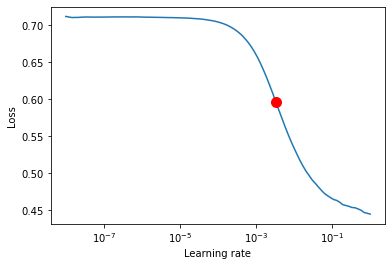

In [24]:
# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

In [25]:
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
new_lr

0.003311311214825908

this does not change existing lr

In [26]:
pcmodel.hparams.learning_rate

5e-05

would need to manually setup

In [ ]:
# # update hparams of the model
# model.hparams.lr = new_lr

### run tune

In [27]:
trainer = pl.Trainer(auto_lr_find=True)
trainer.tune(pcmodel, data_module)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/data/anaconda3/envs/product-category/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name | Type            | Params
-----------------------------------------
0 | bert | DistilBertModel | 65.2 M
1 | W    | Linear          | 37.7 K
-----------------------------------------
37.7 K    Trainable params
65.2 M    Non-trainable params
65.2 M    Total params
260.914   Total estimated model params size (MB)
/data/anaconda3/envs/product-category/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


Restored states from the checkpoint file at /data/git/product-category/notebooks/lr_find_temp_model.ckpt
Learning rate set to 0.003311311214825908


In [28]:
pcmodel.hparams.learning_rate

0.003311311214825908

## run

In [32]:
pl.seed_everything(1234)
trainer.fit(pcmodel, data_module)

Global seed set to 1234

  | Name | Type            | Params
-----------------------------------------
0 | bert | DistilBertModel | 65.2 M
1 | W    | Linear          | 37.7 K
-----------------------------------------
37.7 K    Trainable params
65.2 M    Non-trainable params
65.2 M    Total params
260.914   Total estimated model params size (MB)


/data/anaconda3/envs/product-category/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [34]:
!find $p_out/

/data/git/product-category/data/transformer_20210307A1/


## tensorboard

In [29]:
!find $p_out/tensorboard/

find: ‘/data/git/product-category/data/transformer_20210307A1/tensorboard/’: No such file or directory


## load model

# eval

## csv results

In [30]:
!find $p_out/csv/

find: ‘/data/git/product-category/data/transformer_20210307A1/csv/’: No such file or directory


## run model

In [ ]:
ls $p_out/lightning_logs/version_1/

## demo

In [ ]:
def do_demo(df):
    i2cat = data_module.i2cat
    tokenizer = data_module.tokenizer
    max_seq_length = data_module.max_seq_length
    row = df.sample()
    display(row)
    txt = list(row.txt.values)
    input_ids, attention_mask = mk_tensors(txt, tokenizer, max_seq_length)
    logits = pcmodel(input_ids, attention_mask)[0]
    print('Truth:', sorted(o for o in row.category.values[0].split('|') if o in i2cat))

    top_icats = np.argsort(-logits.detach().numpy())[:5]
    print('Top Preds:',[i2cat[i] for i in top_icats])
    print('Preds 0.5+:',[i2cat[i] for i in np.where(logits>0)[0]])


In [ ]:
do_demo(data_module.df_val)

## save to script

# fin

In [ ]:
!nvidia-smi